In [1]:
import os, sys, time, importlib, json, copy
from datetime import datetime
import numpy as np
from cpuinfo import get_cpu_info
from OuterDeployment.HarrisCorner import *
from SensorModule.Sensor import Sensor
from Tools.PlotTools import VisualTool
from Tools.MapLoader import MapLoader
from Tools.Mask import layer_map

vis=VisualTool(show=True, size=(3,3), save=False)

전체 맵데이터 레이아웃 파악

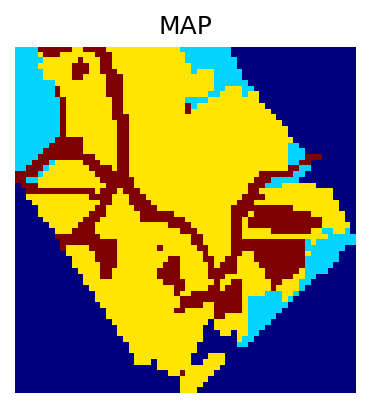

In [2]:
map=MapLoader().load("gangjin.crop1")
vis.showJetMap(map)

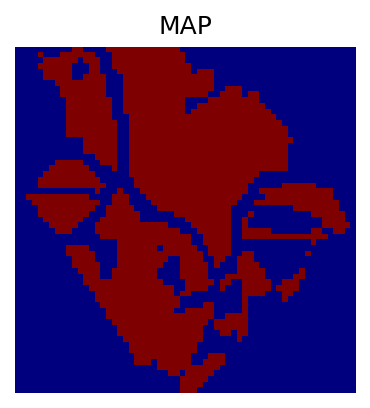

In [3]:
installable_layer = layer_map(map, keep_values=[2])
vis.showJetMap(installable_layer)

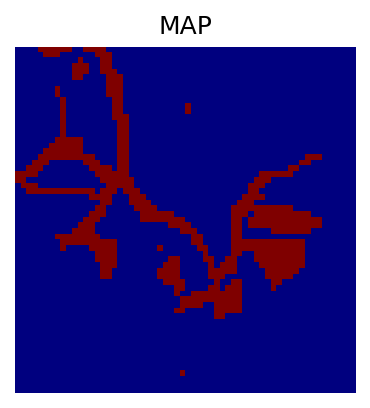

In [4]:
road_layer = layer_map(map, keep_values=[3])
vis.showJetMap(road_layer)

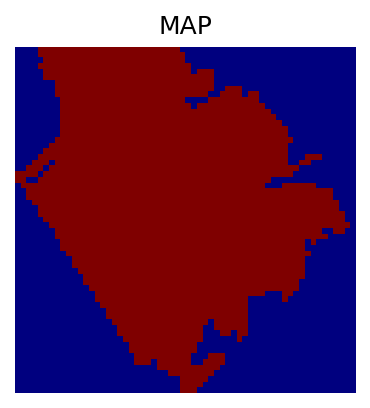

In [5]:
jobsite_layer = layer_map(map, keep_values=[2,3])
vis.showJetMap(jobsite_layer)

센서가 설치가능한 구역 중에서 최외곽센서 설치 가능 지점 탐색

Number of the Outmost-corner Sensors : 7 <class 'list'>


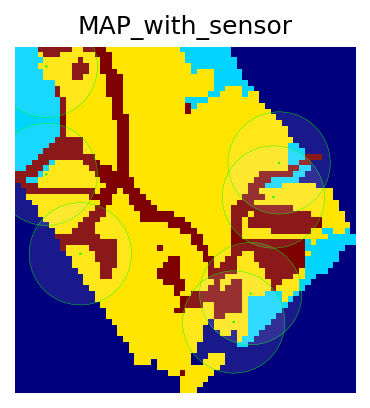

In [6]:
corner_layer = HarrisCorner(installable_layer)

corner_candidate = corner_layer.run(
    map=installable_layer,                
    installable_layer=installable_layer,
    blockSize=3,
    ksize=3,
    k=0.1,
    dilate_size=7
)
print("Number of the Outmost-corner Sensors :",len(corner_candidate), type(corner_candidate))
vis.showJetMap_circle(map, corner_candidate, radius=45)

In [ ]:
from InnerDeployment.GeneticAlgorithm.main import SensorGA

optimized_sensors = SensorGA(
                                installable_map=installable_layer,
                                jobsite_map=jobsite_layer,
                                coverage=9,
                                generations=100,
                                corner_positions=corner_candidate,
                                initial_size=100,
                                selection_size=50,
                                child_chromo_size=100,
                                min_sensors=50,
                                max_sensors=100
                            ).run()

[Gen:001/100] Fitness : (best=-0.24, avg=-0.24, worst=-0.24) | Coverage(best)=1.56% | Numb of sensors : (min=7, avg=7.0, max=7) | BestSensors=7 (corner=7)
[Profile Gen 001] fitness=2.894s | selection=0.000s | repro=6.181s (crossover=0.000s, mutation=6.178s) | calls: crossover~100, mutation~70.0
               fitness_breakdown: ordering=2.856s | score=0.027s | pop=100 

[Gen:002/100] Fitness : (best=-0.24, avg=-0.24, worst=-0.24) | Coverage(best)=1.56% | Numb of sensors : (min=7, avg=7.0, max=7) | BestSensors=7 (corner=7)
[Profile Gen 002] fitness=0.052s | selection=0.000s | repro=5.139s (crossover=0.000s, mutation=5.137s) | calls: crossover~100, mutation~70.0
               fitness_breakdown: ordering=0.014s | score=0.029s | pop=100 

[Gen:003/100] Fitness : (best=-0.24, avg=-0.24, worst=-0.24) | Coverage(best)=1.56% | Numb of sensors : (min=7, avg=7.0, max=7) | BestSensors=7 (corner=7)
[Profile Gen 003] fitness=0.048s | selection=0.000s | repro=6.213s (crossover=0.000s, mutation=6.21

[(36, 32), (21, 16), (20, 37), (39, 17), (25, 44), (37, 41)]


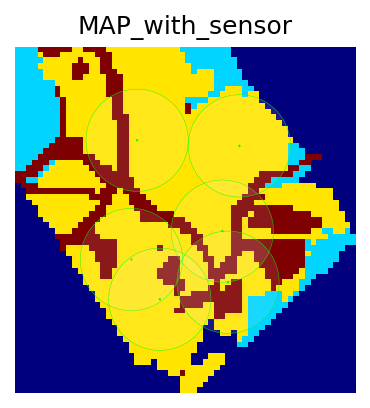

In [ ]:
print(optimized_sensors)
vis.showJetMap_circle(map, optimized_sensors+corner_candidate, radius=45)